# Pre-processing_final_1
This notebook merges 3 preprocessed datasets and prepares for EDA_hourly and model analysis

In [1]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sbs
import geopandas as gpd
import folium 

In [2]:
from pyspark.sql import SparkSession

# Create a spark session with increased memory allocation
spark = (
    SparkSession.builder.appName("ADS Project1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "8g")  # Set the driver memory to 8GB
    .config("spark.executor.memory", "8g")  # Set the executor memory to 8GB
    .getOrCreate()
)

24/08/31 17:50:41 WARN Utils: Your hostname, Hanshis-Laptop.local resolves to a loopback address: 127.0.0.1; using 10.12.218.66 instead (on interface en0)
24/08/31 17:50:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/31 17:50:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/08/31 17:50:42 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
spark.conf.set("spark.sql.parquet.compression.codec","gzip")

## Datasets 

In [4]:
# read the data from preprocessed tlc data
tdf = spark.read.parquet("../data/raw/tlc_df.parquet") 

In [5]:
# read the preprocessed weather data
wdf = spark.read.csv("../data/raw/NYC_weather_raw.csv", header=True, inferSchema=True)


In [6]:
# read the preprocessed event data
edf = spark.read.parquet("../data/raw/NYC_Permitted_Event_Information_Historical.parquet") 

In [7]:
# show 5 rows of the tlc data
tdf.show(5)

+--------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+---------+-------------+-----------+------------+-----------+------------+
|VendorID|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|ehail_fee|trip_duration|pickup_hour|dropoff_hour|pickup_date|dropoff_date|
+--------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+---------+-------------+-----------+------------+-----------+------------+
|       1|              1|          7.1|         1|             false|         249|         179|           1|       32.4|  3.5|   

In [8]:
# schema of the tlc data
tdf.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: boolean (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- ehail_fee: double (nullable = true)
 |-- trip_duration: double (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- dropoff_hour: integer (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- dropoff_date: date (nullable = true)



In [9]:
# show 5 rows of the weather data
wdf.show(5)

+----------+----+-------+------------------+-----+----+----+------+
|      DATE|HOUR|    CIG|               WND|  VIS| TMP| DEW|   SLP|
+----------+----+-------+------------------+-----+----+----+------+
|2023-07-01|   0|22000.0|2.6319672131147542|965.6|23.9|13.3|1017.1|
|2023-07-01|   1|22000.0|2.6319672131147542|965.6|23.3|13.3|1017.6|
|2023-07-01|   2|22000.0|2.6319672131147542|965.6|23.3|12.8|1017.8|
|2023-07-01|   3|22000.0|               3.1|965.6|22.8|12.8|1017.7|
|2023-07-01|   4|22000.0|               1.5|965.6|22.8|11.7|1017.4|
+----------+----+-------+------------------+-----+----+----+------+
only showing top 5 rows



In [10]:
# show 5 rows of the event data
edf.show(5)

+--------+----------+----------+----------+--------+-------------+-------------+--------------------+
|Event ID|Start Date|Start Hour|  End Date|End Hour|   Event Type|Event Borough|      Event Location|
+--------+----------+----------+----------+--------+-------------+-------------+--------------------+
|  683185|2023-11-17|         8|2023-11-17|      23|Special Event|     Brooklyn|Prospect Park: Pi...|
|  683046|2023-10-13|         8|2023-10-13|      23|Special Event|     Brooklyn|Prospect Park: Pi...|
|  682144|2023-07-14|         8|2023-07-14|      23|Special Event|     Brooklyn|Prospect Park: Pi...|
|  681104|2023-09-17|        15|2023-09-17|      20|Special Event|     Brooklyn|  Fulton Park: Plaza|
|  683192|2023-11-25|         8|2023-11-25|      23|Special Event|     Brooklyn|Prospect Park: Pi...|
+--------+----------+----------+----------+--------+-------------+-------------+--------------------+
only showing top 5 rows



In [11]:
# check min and max date for edf
edf.select(F.min("Start Date"), F.max("Start Date")).show()

+---------------+---------------+
|min(Start Date)|max(Start Date)|
+---------------+---------------+
|     2023-07-01|     2023-12-30|
+---------------+---------------+



## Aggregation for hourly

### Map taxi zones to boroughs 

In [12]:
# Load the zones DataFrame
zones = spark.read.csv("../data/landing/external/taxi_zones.csv", header=True, inferSchema=True)

In [13]:
# Join the tdf DataFrame with zones to get the borough for PULocationID
tdf = tdf.join(zones.select('LocationID', 'borough').withColumnRenamed('borough', 'PUBorough'),
               tdf['PULocationID'] == zones['LocationID'], 'left').drop('LocationID')

# Join the tdf DataFrame with zones to get the borough for DOLocationID
tdf = tdf.join(zones.select('LocationID', 'borough').withColumnRenamed('borough', 'DOBorough'),
               tdf['DOLocationID'] == zones['LocationID'], 'left').drop('LocationID')


In [14]:
# Convert pickup_date and pickup_hour to a timestamp and create Time column
tdf = tdf.withColumn(
    'Time', 
    to_timestamp(concat_ws(' ', col('pickup_date'), col('pickup_hour')))
)

df_hourly_agg = tdf.groupBy(['pickup_date', 'pickup_hour', "PUBorough"]).agg({
    '*': 'count',
}).withColumnRenamed('count(1)', 'hourly_trip_count')
df_daily_agg = tdf.groupBy(['pickup_date', "PUBorough"]).agg({
    '*': 'count',
})

### Aggregation of number of events

In [15]:
# Aggregate the number of events per date, hour, and borough
edf_hourly = edf.groupBy('Start Date', 'Start Hour', 'Event Borough').agg(count('Event ID').alias('Number of Events'))

In [16]:
edf_hourly.show(5)

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=28875Kb max_used=28875Kb free=102196Kb
 bounds [0x00000001081e8000, 0x0000000109e48000, 0x00000001101e8000]
 total_blobs=11006 nmethods=9996 adapters=922
 compilation: disabled (not enough contiguous free space left)
+----------+----------+-------------+----------------+
|Start Date|Start Hour|Event Borough|Number of Events|
+----------+----------+-------------+----------------+
|2023-08-14|        10|    Manhattan|              41|
|2023-08-19|         8|       Queens|              87|
|2023-07-28|         8|        Bronx|              46|
|2023-07-09|        10|        Bronx|              33|
|2023-07-29|        14|    Manhattan|              26|
+----------+----------+-------------+----------------+
only showing top 5 rows



## Merge datasets

In [17]:
# Step 1: Create unified datetime columns in each dataset

# For tdf (taxi dataset)
df_hourly_agg = df_hourly_agg.withColumn("datetime", to_timestamp(concat_ws(" ", col("pickup_date"), col("pickup_hour")), "yyyy-MM-dd H"))

# For edf (event dataset)
edf_hourly = edf_hourly.withColumn("datetime", to_timestamp(concat_ws(" ", col("Start Date"), col("Start Hour")), "yyyy-MM-dd H"))
edf_hourly = edf_hourly.withColumnRenamed("Event Borough", "PUBorough")

# For wdf (weather dataset)
wdf = wdf.withColumn("datetime", to_timestamp(col("DATE"), "yyyy-MM-dd HH:mm:ss"))

# Step 2: Join tdf (taxi dataset) with edf (event dataset) on datetime and borough
tdf_edf = df_hourly_agg.join(edf_hourly, on=["datetime", "PUBorough"], how="left")

# Step 3: Join the result with the weather dataset on datetime only (since weather data is from one station)
final_df_hourly = tdf_edf.join(wdf, 
                        on="datetime", 
                        how="left")

In [18]:
# print the schema of the final dataframe
final_df_hourly.printSchema()

root
 |-- datetime: timestamp (nullable = true)
 |-- PUBorough: string (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- hourly_trip_count: long (nullable = false)
 |-- Start Date: date (nullable = true)
 |-- Start Hour: integer (nullable = true)
 |-- Number of Events: long (nullable = true)
 |-- DATE: date (nullable = true)
 |-- HOUR: integer (nullable = true)
 |-- CIG: double (nullable = true)
 |-- WND: double (nullable = true)
 |-- VIS: double (nullable = true)
 |-- TMP: double (nullable = true)
 |-- DEW: double (nullable = true)
 |-- SLP: double (nullable = true)



In [20]:
# Drop the redundant datetime columns after the final join 
final_df = final_df_hourly.drop('Start Date', 'Start Hour', 'DATE', 'HOUR')

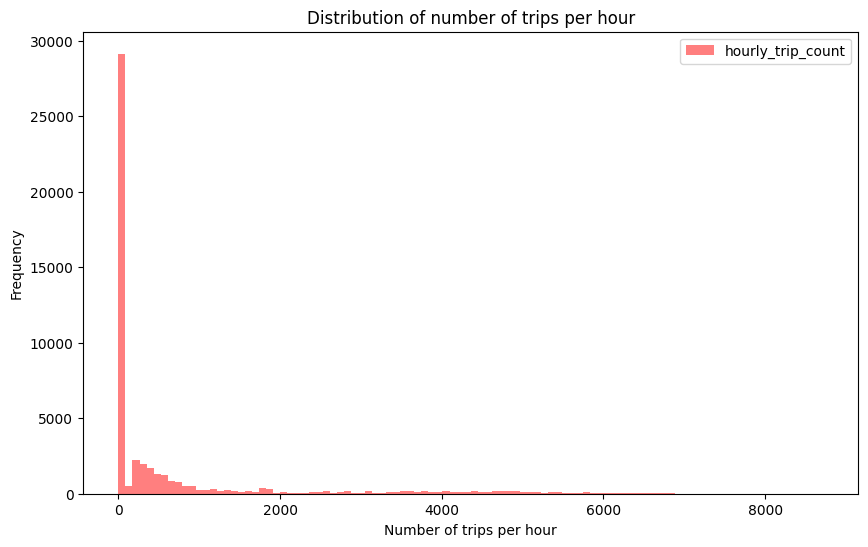

In [22]:
# check distribution of number of trips per hour on a plot
final_df.select('hourly_trip_count').toPandas().plot.hist(bins=100, alpha=0.5, color='r', figsize=(10, 6))
plt.xlabel('Number of trips per hour')
plt.ylabel('Frequency')
plt.title('Distribution of number of trips per hour')
plt.show()

## Preprocessing

### Handling missing data
The assumption is no events occured if number of event in Null


In [150]:
# Impute missing values in Number of Events column with 0
final_df = final_df.fillna(0, subset=['Number of Events'])

In [151]:
# Define a window specification with proper partitioning
window_spec = Window.partitionBy("pickup_date").orderBy("pickup_hour").rowsBetween(-sys.maxsize, 0)

# Apply forward fill to the missing weather columns
final_df = final_df.withColumn("CIG", last(col("CIG"), ignorenulls=True).over(window_spec))
final_df = final_df.withColumn("WND", last(col("WND"), ignorenulls=True).over(window_spec))
final_df = final_df.withColumn("VIS", last(col("VIS"), ignorenulls=True).over(window_spec))
final_df = final_df.withColumn("TMP", last(col("TMP"), ignorenulls=True).over(window_spec))
final_df = final_df.withColumn("DEW", last(col("DEW"), ignorenulls=True).over(window_spec))
final_df = final_df.withColumn("SLP", last(col("SLP"), ignorenulls=True).over(window_spec))

In [152]:
# drop the null values and record % of remaining rows
total_rows = final_df.count()
final_df = final_df.dropna()
remaining_rows = final_df.count()

print(f"Remaining rows after dropping missing values: {remaining_rows} out of {total_rows}")

# Print percentage of rows remaining
print(f"Percentage of rows remaining: {remaining_rows / total_rows * 100:.2f}%")

Remaining rows after dropping missing values: 38461 out of 38461
Percentage of rows remaining: 100.00%


In [153]:
# check schema
final_df.printSchema()

root
 |-- datetime: timestamp (nullable = true)
 |-- PUBorough: string (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- hourly_trip_count: long (nullable = false)
 |-- Number of Events: long (nullable = true)
 |-- CIG: double (nullable = true)
 |-- WND: double (nullable = true)
 |-- VIS: double (nullable = true)
 |-- TMP: double (nullable = true)
 |-- DEW: double (nullable = true)
 |-- SLP: double (nullable = true)



## Export for EDA_1

In [154]:
# save the merged data and overwrite the previous one
final_df.write.parquet("../data/curated/merged_data/first_cleaned.parquet")

24/08/30 16:10:05 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE